In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter


In [32]:
transport_type = {-1: 'walking',0: 'tram', 1: 'subway', 2: 'rail',
                  3: 'bus', 4: 'ferry', 5: 'cablecar', 6: 'gondola', 7: 'funicular'}

In [33]:
def get_list_cities_names():
    cities = ['adelaide', 'antofagasta', 'athens', 'belfast', 'berlin', 'bordeaux', 'brisbane', 'canberra',
              'detroit', 'dublin', 'grenoble', 'helsinki', 'kuopio', 'lisbon', 'luxembourg', 'melbourne',
              'nantes', 'palermo', 'paris', 'prague', 'rennes', 'rome', 'sydney', 'toulouse', 'turku',
              'venice', 'winnipeg']
    return cities

In [18]:
def load_nodes(net, path):
    '''
    Load nodes from network_nodes.csv
    nodes are stops
    
    '''
    nodes_info = pd.read_csv(path, delimiter=";")
    df = pd.DataFrame(nodes_info, columns=['stop_I', 'lat', 'lon', 'name'])
    for index, row in df.iterrows():
        net.add_node(row['stop_I'], coords=(row['lat'], row['lon']), pos=(row['lon'], row['lat']))

In [19]:
def load_edges(net, path):
    '''
    Load edges from network_combined.csv
    edges are routes between two stops
    
    '''
    edges_info = pd.read_csv(path, delimiter=";")
    df = pd.DataFrame(edges_info, columns=['from_stop_I', 'to_stop_I', 'd', 'duration_avg', 'n_vehicles',
                                           'route_I_counts', 'route_type'])
    for index, row in df.iterrows():
        net.add_edge(row['from_stop_I'], row['to_stop_I'],  type=transport_type[row['route_type']])



In [35]:
def create_network(city):
    '''
    Create network in L-space for each city
    (Stops are represented by nodes; they are linked if two consecutive stops have a share route.)
    
    '''
    nodes_path = 'data/'+city+'/network_nodes.csv'
    edges_path = 'data/' + city + '/network_combined.csv'
    
    net = nx.Graph()
    load_nodes(net, nodes_path)
    load_edges(net, edges_path)

    return net

    

In [36]:
def transport_count_type(net,city):
    '''
    Represents number of different transportation types
    
    '''
    print(Counter(nx.get_edge_attributes(net, 'type').values()))

In [38]:
def get_component_size_dist(net):
    '''
    Copute component distribution for the network
    
    '''
    dist = {}
    sizes = []
    for comp in sorted((net.subgraph(c) for c in nx.connected_components(net)), key = len):
        sizes.append(len(comp))
    for size in sizes:
        if size in dist:
            continue
        else:
            dist[size] = sizes.count(size)
    
    return dist


In [40]:
def compute_measures(city):
    net = create_network(city)
    GCC = max((net.subgraph(c) for c in nx.connected_components(net)), key=len) # Guant component 
    n =  nx.number_of_nodes(net) #Number of nodes
    m = nx.number_of_edges(net) #Number of edges
    d = nx.density(net) #Network density
    D = nx.diameter(GCC) #Network diameter
    l = nx.average_shortest_path_length(GCC) #Average shortest path
    c = nx.average_clustering(net, count_zeros=True) #Clustering coefficient
    k = 2*net.number_of_edges() / float(net.number_of_nodes()) #Average degree
    cmps = len(list(net.subgraph(c) for c in nx.connected_components(net))) # Number of component in the network
    a = nx.degree_assortativity_coefficient(net) #Assortativity
    
    return[n,m,d,D,l,c,k,cmps,a]



In [24]:
def ccdf(degree_dist):
    
    degree_dist = np.array(degree_dist)
    unique_degree_dist = np.unique(degree_dist) 
    ccdf = []
    normalizer=float(degree_dist.size) 

    for x in unique_degree_dist:
        ccdf.append((degree_dist[np.where(degree_dist >= x)].size)/normalizer)   

    return (unique_degree_dist.tolist(), ccdf)

In [41]:
def plot_ccdfs(x,datavecs,markers, labels):
    '''
    Plots in a single figure the complementary cumulative distributions
    
    '''
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111)
    for x_values, y_values, marker, label  in zip(x,datavecs, markers, labels):    
        ax.loglog(x_values, y_values, marker, label = label) 

    ax.set_xlabel('Degree' ) 
    ax.set_ylabel('1-CDF degree') 
    ax.legend(loc=0)
    ax.set_title('Degree distribution in L_space')
    plt.savefig("Degree_distribution_L_space.pdf", dpi=150)


    plt.show()

    return fig

In [42]:
def plot_degree_clustering(degrees,clusteringvec, markers, labels):
   
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111)
    for degree,clustering, marker, label  in zip(degrees,clusteringvec, markers, labels):    
        
        df = pd.DataFrame({"degree":degree,"clustering":clustering})
        df = df.sort_values(["degree"])
        mean_cluster = df.groupby("degree").mean()
        bins = np.array(mean_cluster.index.tolist())
        
        ax.plot(bins,mean_cluster,marker, label = label)
        
    ax.set_xlabel('Degree') 
    ax.set_ylabel('Clustering Coefficient (ci)') 
    ax.set_title('Clustering coefficient in L_space')

    ax.legend(loc=0)
    plt.savefig("Clustering_coefficient_L_space.pdf", dpi=150)

    plt.show()
    return fig

In [43]:
def get_centrality_measures(network):
    tol = 10**-1
    nodes = network.nodes()
    degrees = nx.degree_centrality(network)
    betweenness = nx.betweenness_centrality(network, normalized=True)
    closeness = nx.closeness_centrality(network)
    eigenvector_centrality = nx.eigenvector_centrality(network, tol = tol) 
   
    degree = np.array([v for k, v in  sorted(degrees.items(), key=lambda pair: list(nodes).index(pair[0]))])
    betweenness =np.array([v for k, v in  sorted(betweenness.items(), key=lambda  item: item[1], reverse = True)])
    closeness = np.array([v for k, v in  sorted(closeness.items(), key=lambda  item: item[1], reverse = True)])
    eigenvector_centrality = np.array([v for k, v in  sorted(eigenvector_centrality.items(),
                                                             key=lambda  item: item[1], reverse = True)])
    
    
    return [degree, betweenness, closeness, eigenvector_centrality]

In [ ]:
cities = get_list_cities_names()
cities_ccdf_degree = {}
cities_degree = {}
cities_clustering = {}
cities_total_degree = {}
for i , city in enumerate(cities):
    print(30*'-', city, 30*'-')
    net = nx.Graph()
    path_nodes = './data/'+city+'/network_nodes.csv'
    load_nodes(net, path_nodes)
    path_edges = './data/'+city+'/network_combined.csv'
    load_edges(net, path_edges)
    create_network(city)
    transport_count_type(net,city)
    compute_measures(net, city)
    degrees = [net.degree(node) for node in nx.nodes(net)]
    cities_degree[i],cities_ccdf_degree[i]=ccdf(degrees)
    clustering = list(nx.clustering(net).values())
    cities_clustering[i]= clustering
    cities_total_degree[i]= degrees
    

------------------------------ adelaide ------------------------------
Counter({'bus': 8950, 'rail': 230, 'tram': 54})
Number of nodes:  7548
Number of edges:  9234
Density:  0.0003242004582622982
Network diameter:  89
Average shortest path length:  23.60105232057513
Average clustering coefficient:  0.022585472585472596
Average degree:  2.4467408585055646
Number of component in the networek:  4
Assortativity:  0.34179842117647846
Component distribution {28: 1, 108: 1, 175: 1, 7237: 1}
Average degree conectivity:  {1: 2.8363636363636364, 2: 2.4515179392824287, 4: 3.432801822323462, 5: 4.014193548387097, 3: 2.9908396946564886, 6: 4.4559386973180075, 21: 4.0476190476190474, 7: 4.48051948051948, 8: 4.258333333333334, 11: 4.7272727272727275, 10: 4.55, 15: 4.533333333333333, 13: 4.384615384615385, 9: 5.222222222222222, 12: 5.416666666666667}
------------------------------ antofagasta ------------------------------
Counter({'bus': 963})
Number of nodes:  650
Number of edges:  963
Density:  0.

Counter({'bus': 8598, 'tram': 301, 'rail': 101, 'subway': 20, 'ferry': 2})
Number of nodes:  6986
Number of edges:  9022
Density:  0.00036977523919912636
Network diameter:  74
Average shortest path length:  25.305112664683058
Average clustering coefficient:  0.021385370204436878
Average degree:  2.5828800458058976
Number of component in the networek:  9
Assortativity:  0.13677671967163066
Component distribution {2: 5, 3: 1, 19: 1, 75: 1, 6879: 1}
Average degree conectivity:  {2: 2.7064623425991923, 3: 3.1263771872974724, 5: 3.464655172413793, 6: 3.2151898734177213, 4: 3.311946902654867, 9: 3.4761904761904763, 1: 4.612903225806452, 7: 3.3852813852813854, 10: 2.533333333333333, 11: 3.090909090909091, 8: 3.2395833333333335, 12: 2.3333333333333335}
------------------------------ kuopio ------------------------------
Counter({'bus': 699})
Number of nodes:  549
Number of edges:  699
Density:  0.004646803079254916
Network diameter:  29
Average shortest path length:  10.578668564199873
Average

Counter({'bus': 27545, 'rail': 960, 'ferry': 146, 'tram': 44})
Number of nodes:  24063
Number of edges:  28695
Density:  9.911850231974082e-05
Network diameter:  115


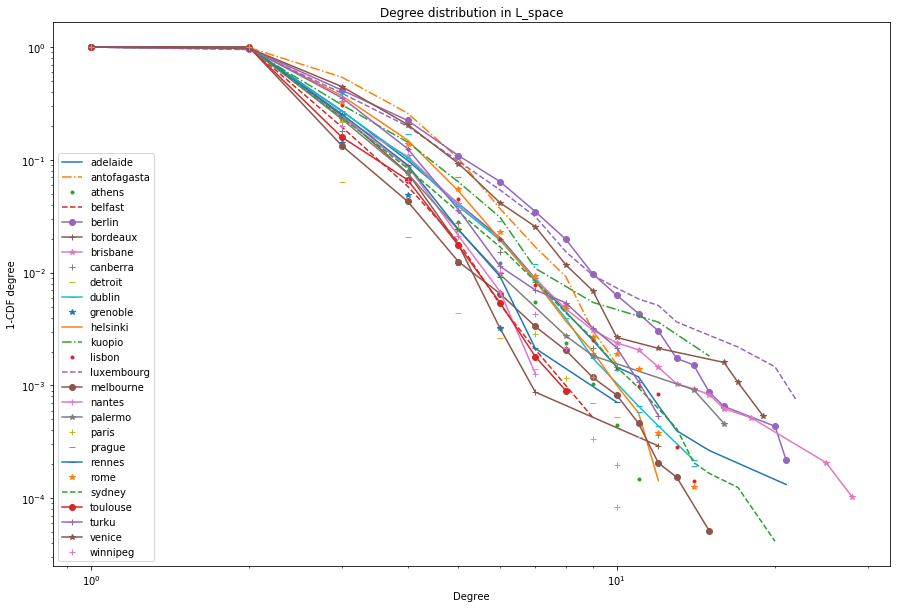

In [77]:
labels = cities
markers = [ '-', '-.','.', '--', '-o', '-+','-*','+','_','_-','*','-', '-.','.', '--', 
           '-o', '-+','-*','+','_','_-','*', '--', '-o', '-+','-*','+']
datavecs = [list(v) for v in cities_ccdf_degree.values()]
x = [list(v) for v in cities_degree.values()]
plot_ccdfs(x,datavecs, markers,labels);

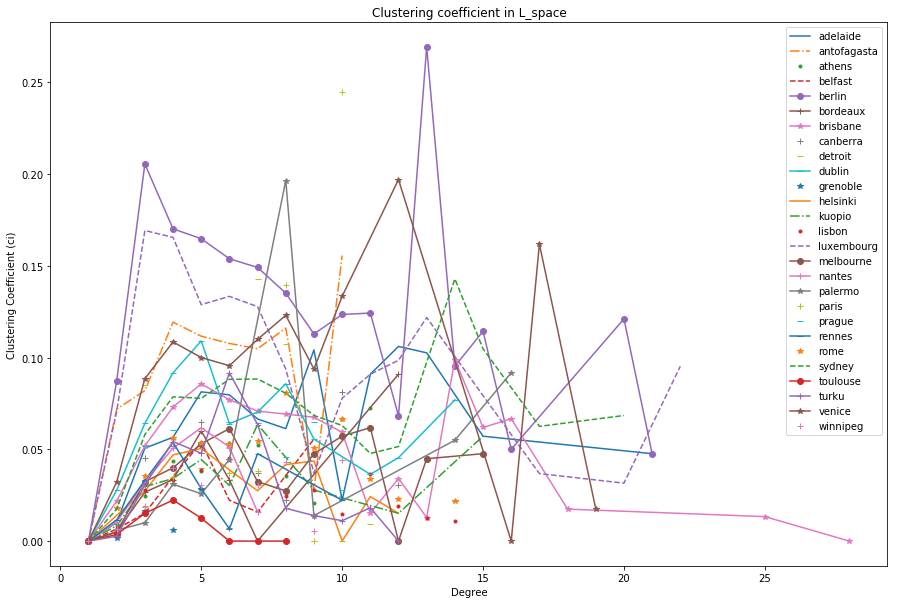

In [82]:
labels = cities
markers = [ '-', '-.','.', '--', '-o', '-+','-*','+','_','_-','*','-', '-.','.', '--', 
           '-o', '-+','-*','+','_','_-','*', '--', '-o', '-+','-*','+']
clusteringvec = [list(v) for v in cities_clustering.values()]
deg =[list(v) for v in cities_total_degree.values()]
plot_degree_clustering(deg,clusteringvec,markers, labels);